<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal LLM using Google's Gemini model for image understanding and build Retrieval Augmented Generation with LlamaIndex

In this notebook, we show how to use Google's Gemini Vision models for image understanding.

First, we show several functions we are now supporting for Gemini:
* `complete` (both sync and async): for a single prompt and list of images
* `chat` (both sync and async): for multiple chat messages
* `stream complete` (both sync and async): for steaming output of complete
* `stream chat` (both sync and async): for steaming output of chat

For the 2nd part of this notebook, we try to use `Gemini` + `Pydantic` to parse structured information for images from Google Maps.
* Define the desired Pydantic class with attribution fields
* Let `gemini-pro-vision` model understand each image and output structured results

For the 3rd part of this notebook, we propose using Gemini & LlamaIndex to build a simple `Retrieval Augmented Generation` Flow for a small Google Maps restaurant dataset.
* Build vector index based on the structured outputs from Step 2
* Using the `gemini-pro` model to synthesize the results and recommends restaurants based on user query.

Note: `google-generativeai` is only available for certain countries and regions.

In [ ]:
%pip install llama-index-multi-modal-llms-gemini
%pip install llama-index-vector-stores-qdrant
%pip install llama-index-embeddings-gemini
%pip install llama-index-llms-gemini

In [ ]:
!pip install llama-index 'google-generativeai>=0.3.0' matplotlib qdrant_client

##  Use Gemini to understand Images from URLs

In [ ]:
%env GOOGLE_API_KEY=...

In [ ]:
import os

GOOGLE_API_KEY = ""  # add your GOOGLE API key here
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## Initialize `GeminiMultiModal` and Load Images from URLs

In [ ]:
from llama_index.llms.gemini import Gemini
from llama_index.core.llms import ChatMessage, ImageBlock


image_urls = [
    "https://storage.googleapis.com/generativeai-downloads/data/scene.jpg",
    # Add yours here!
]
gemini_pro = Gemini(model_name="models/gemini-1.5-flash")
msg = ChatMessage("Identify the city where this photo was taken.")
for img_url in image_urls:
    msg.blocks.append(ImageBlock(url=img_url))

https://storage.googleapis.com/generativeai-downloads/data/scene.jpg


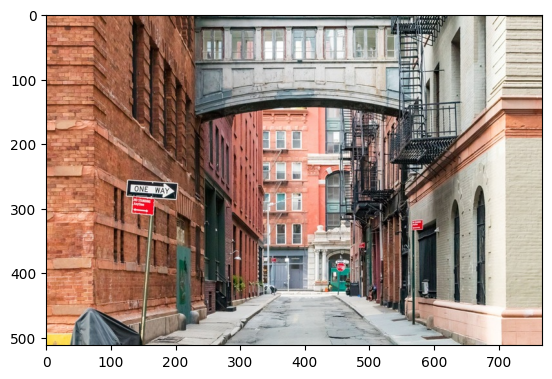

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

img_response = requests.get(image_urls[0])
print(image_urls[0])
img = Image.open(BytesIO(img_response.content))
plt.imshow(img)

### Chat using images in the prompt

In [ ]:
response = gemini_pro.chat(messages=[msg])

In [ ]:
print(response.message.content)

That's New York City.  More specifically, the photo shows a street in the **SoHo** neighborhood.  The distinctive cast-iron architecture and the pedestrian bridge are characteristic of that area.



### Stream chat with images

In [ ]:
stream_response = gemini_pro.stream_chat(messages=[msg])

In [ ]:
import time


for r in stream_response:
    print(r.delta, end="")
    # Add an artificial wait to make streaming visible in the notebook
    time.sleep(0.5)

That's New York City.  More specifically, the photo was taken in the **West Village** neighborhood of Manhattan.  The distinctive architecture and the pedestrian bridge are strong clues.


### Async support

In [ ]:
response_achat = await gemini_pro.achat(messages=[msg])

In [ ]:
print(response_achat.message.content)

That's New York City.  More specifically, the photo was taken in the **West Village** neighborhood of Manhattan.  The distinctive architecture and the pedestrian bridge are strong clues.



Let's see how to stream asynchronously:

In [ ]:
import asyncio

streaming_handler = await gemini_pro.astream_chat(messages=[msg])
async for chunk in streaming_handler:
    print(chunk.delta, end="")
    # Add an artificial wait to make streaming visible in the notebook
    await asyncio.sleep(0.5)

That's New York City.  More specifically, the photo was taken in the **West Village** neighborhood of Manhattan.  The distinctive architecture and the pedestrian bridge are strong clues.


## Complete with Two images

In [ ]:
image_urls = [
    "https://picsum.photos/id/1/200/300",
    "https://picsum.photos/id/26/200/300",
]


msg = ChatMessage("Is there any relationship between these images?")
for img_url in image_urls:
    msg.blocks.append(ImageBlock(url=img_url))

response_multi = gemini_pro.chat(messages=[msg])

In [ ]:
print(response_multi.message.content)

Yes, there is a relationship between the two images.  Both images depict aspects of a **professional or business-casual lifestyle**.

* **Image 1:** Shows someone working on a laptop, suggesting remote work, freelancing, or a business-related task.

* **Image 2:** Shows a flat lay of accessories commonly associated with a professional or stylish individual: sunglasses, a bow tie, a pen, a watch, glasses, and a phone.  These items suggest a certain level of personal style and preparedness often associated with business or professional settings.

The connection is indirect but thematic.  They both visually represent elements of a similar lifestyle or persona.



## 2nd Part: `Gemini` + `Pydantic` for Structured Output Parsing from an Image

* Leveraging Gemini for the image reasoning
* Use Pydantic program to generate structured output from the image reasoning results of Gemini

### Download example images for Gemini to understand

In [ ]:
from pathlib import Path

input_image_path = Path("google_restaurants")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

In [ ]:
!curl -sL "https://docs.google.com/uc?export=download&id=1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg" -o ./google_restaurants/miami.png
!curl -sL "https://docs.google.com/uc?export=download&id=1dYZy17bD6pSsEyACXx9fRMNx93ok-kTJ" -o ./google_restaurants/orlando.png
!curl -sL "https://docs.google.com/uc?export=download&id=1ShPnYVc1iL_TA1t7ErCFEAHT74-qvMrn" -o ./google_restaurants/sf.png
!curl -sL "https://docs.google.com/uc?export=download&id=1WjISWnatHjwL4z5VD_9o09ORWhRJuYqm" -o ./google_restaurants/toronto.png

### Define the Pydantic Class for the Structured Parser

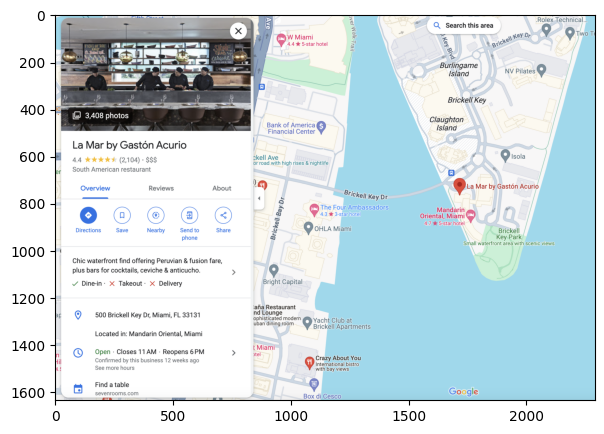

In [ ]:
from pydantic import BaseModel
from PIL import Image
import matplotlib.pyplot as plt


class GoogleRestaurant(BaseModel):
    """Data model for a Google Restaurant."""

    restaurant: str
    food: str
    location: str
    category: str
    hours: str
    price: str
    rating: float
    review: str
    description: str
    nearby_tourist_places: str


google_image_url = "./google_restaurants/miami.png"
image = Image.open(google_image_url).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

### Call the Pydantic Program and Generate Structured Output

In [ ]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser

prompt_template_str = """\
    can you summarize what is in the image\
    and return the answer with json format \
"""


def pydantic_gemini(
    model_name, output_class, image_documents, prompt_template_str
):
    gemini_llm = GeminiMultiModal(model_name=model_name)

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response

### Generate the Pydantic Structured Output via Gemini Vision Model

In [ ]:
from llama_index.core import SimpleDirectoryReader

google_image_documents = SimpleDirectoryReader(
    "./google_restaurants"
).load_data()

results = []
for img_doc in google_image_documents:
    pydantic_response = pydantic_gemini(
        "models/gemini-1.5-flash",
        GoogleRestaurant,
        [img_doc],
        prompt_template_str,
    )
    # only output the results for miami for example along with image
    if "miami" in img_doc.image_path:
        for r in pydantic_response:
            print(r)
    results.append(pydantic_response)

> Raw output: ```json
{
  "restaurant": "La Mar by Gaston Acurio",
  "food": "Peruvian & fusion",
  "location": "500 Brickell Key Dr, Miami, FL 33131",
  "category": "South American restaurant",
  "hours": "Opens 6PM, Closes 11 PM",
  "price": "$$$",
  "rating": 4.4,
  "review": "Chic waterfront offering Peruvian & fusion fare, plus bars for cocktails, ceviche & anticuchos.",
  "description": "Chic waterfront offering Peruvian & fusion fare, plus bars for cocktails, ceviche & anticuchos.",
  "nearby_tourist_places": "Brickell Key area with scenic views"
}
```

('restaurant', 'La Mar by Gaston Acurio')
('food', 'Peruvian & fusion')
('location', '500 Brickell Key Dr, Miami, FL 33131')
('category', 'South American restaurant')
('hours', 'Opens 6PM, Closes 11 PM')
('price', '$$$')
('rating', 4.4)
('review', 'Chic waterfront offering Peruvian & fusion fare, plus bars for cocktails, ceviche & anticuchos.')
('description', 'Chic waterfront offering Peruvian & fusion fare, plus bars for cockta

`Observation`:
* Gemini perfectly generates all the meta information we need for the Pydantic class
* It could also recognizes the nearby park from `Google Maps` 

## 3rd Part: Build Multi-Modal RAG for Restaurant Recommendation

Our stack consists of Gemini + LlamaIndex + Pydantic structured output capabilities

### Construct Text Nodes for Building Vector Store. Store metadata and description for each restaurant.

In [ ]:
from llama_index.core.schema import TextNode

nodes = []
for res in results:
    text_node = TextNode()
    metadata = {}
    for r in res:
        # set description as text of TextNode
        if r[0] == "description":
            text_node.text = r[1]
        else:
            metadata[r[0]] = r[1]
    text_node.metadata = metadata
    nodes.append(text_node)

### Using Gemini Embedding for building Vector Store for Dense retrieval. Index Restaurants as nodes into Vector Store

In [ ]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.embeddings.gemini import GeminiEmbedding
from llama_index.llms.gemini import Gemini
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import Settings
from llama_index.core import StorageContext
import qdrant_client


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini_3")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# Using the embedding model to Gemini
Settings.embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)
Settings.llm = Gemini(api_key=GOOGLE_API_KEY)

storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    storage_context=storage_context,
)

### Using Gemini to synthesize the results and recommend the restaurants to user 

In [ ]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
)

response = query_engine.query(
    "recommend a Orlando restaurant for me and its nearby tourist places"
)
print(response)

For a delightful dining experience, I recommend Mythos Restaurant, known for its American cuisine and unique underwater theme. Overlooking Universal Studios' Inland Sea, this restaurant offers a captivating ambiance. After your meal, explore the nearby tourist attractions such as Universal's Islands of Adventure, Skull Island: Reign of Kong, The Wizarding World of Harry Potter, Jurassic Park River Adventure, and Hollywood Rip Ride Rockit, all located near Mythos Restaurant.
